In [18]:
import pandas as pd
data = pd.read_csv('./000660.csv')

In [19]:
data_000660 = data[['종가','거래량']]

In [20]:
data_000660.rename(columns={'종가':'Close',
                     '거래량':'Volume'},
            inplace=True)

C:\TempFolder\ipykernel_14264\75747287.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_000660.rename(columns={'종가':'Close',


In [23]:
data_500 = data_000660[int(len(data_000660)-1000) : int(len(data_000660)-500)]

In [24]:
data_500

,Close,Volume
16390,247000,1784
16391,246500,2120
16392,247000,4095
16393,246500,7551
16394,247000,2014
...,...,...
16885,192900,8722
16886,193000,23417
16887,193200,83006
16888,193700,30537


Epoch 1/200
4/4 [==============================] - 1s 13ms/steploss: 3.15


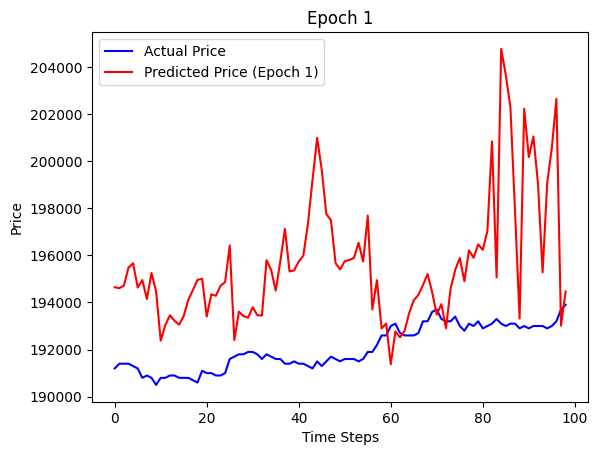

10/10 [==============================] - 6s 225ms/step - loss: 2.8955 - val_loss: 0.0011
Epoch 2/200
4/4 [==============================] - 0s 13ms/steploss: 0.12


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 73ms/step - loss: 0.1251 - val_loss: 0.1050
Epoch 3/200
4/4 [==============================] - 0s 15ms/steploss: 0.08


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0782 - val_loss: 0.0798
Epoch 4/200
4/4 [==============================] - 0s 12ms/steploss: 0.06


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 65ms/step - loss: 0.0595 - val_loss: 0.0023
Epoch 5/200
4/4 [==============================] - 0s 27ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0524 - val_loss: 0.0016
Epoch 6/200
4/4 [==============================] - 0s 12ms/steploss: 0.04


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 90ms/step - loss: 0.0446 - val_loss: 0.0012
Epoch 7/200
4/4 [==============================] - 0s 14ms/steploss: 0.03


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 66ms/step - loss: 0.0401 - val_loss: 0.0037
Epoch 8/200
4/4 [==============================] - 0s 13ms/steploss: 0.03


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0357 - val_loss: 6.3375e-04
Epoch 9/200
4/4 [==============================] - 0s 16ms/steploss: 0.03


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 65ms/step - loss: 0.0342 - val_loss: 0.0065
Epoch 10/200
4/4 [==============================] - 0s 14ms/steploss: 0.03


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 73ms/step - loss: 0.0319 - val_loss: 0.0046
Epoch 11/200
4/4 [==============================] - 0s 13ms/steploss: 0.02


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 62ms/step - loss: 0.0294 - val_loss: 0.0493
Epoch 12/200
4/4 [==============================] - 0s 12ms/steploss: 0.02


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 64ms/step - loss: 0.0281 - val_loss: 0.0152
Epoch 13/200
4/4 [==============================] - 0s 14ms/steploss: 0.02


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 77ms/step - loss: 0.0256 - val_loss: 5.1851e-04
Epoch 14/200
4/4 [==============================] - 0s 14ms/steploss: 0.02


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 92ms/step - loss: 0.0212 - val_loss: 0.0016
Epoch 15/200
4/4 [==============================] - 0s 19ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 95ms/step - loss: 0.0239 - val_loss: 0.0013
Epoch 16/200
4/4 [==============================] - 0s 20ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 94ms/step - loss: 0.0169 - val_loss: 9.6083e-04
Epoch 17/200
4/4 [==============================] - 0s 18ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 89ms/step - loss: 0.0186 - val_loss: 0.0446
Epoch 18/200
4/4 [==============================] - 0s 18ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 99ms/step - loss: 0.0156 - val_loss: 5.1944e-04
Epoch 19/200
4/4 [==============================] - 0s 14ms/steploss: 0.01


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 84ms/step - loss: 0.0142 - val_loss: 0.0036
Epoch 20/200
4/4 [==============================] - 0s 23ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 109ms/step - loss: 0.0137 - val_loss: 0.0184
Epoch 21/200
4/4 [==============================] - 0s 13ms/steploss: 0.01


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 65ms/step - loss: 0.0149 - val_loss: 6.1802e-04
Epoch 22/200
4/4 [==============================] - 0s 13ms/steploss: 0.01


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 76ms/step - loss: 0.0150 - val_loss: 0.0023
Epoch 23/200
4/4 [==============================] - 0s 12ms/steploss: 0.01


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 66ms/step - loss: 0.0123 - val_loss: 0.0088
Epoch 24/200
4/4 [==============================] - 0s 12ms/steploss: 0.01


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 77ms/step - loss: 0.0101 - val_loss: 0.0035
Epoch 25/200
4/4 [==============================] - 0s 23ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 82ms/step - loss: 0.0086 - val_loss: 0.0028
Epoch 26/200
4/4 [==============================] - 0s 19ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 80ms/step - loss: 0.0104 - val_loss: 0.0055
Epoch 27/200
4/4 [==============================] - 0s 16ms/steploss: 0.01


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 82ms/step - loss: 0.0100 - val_loss: 0.0031
Epoch 28/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 80ms/step - loss: 0.0083 - val_loss: 0.0028
Epoch 29/200
4/4 [==============================] - 0s 19ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 81ms/step - loss: 0.0067 - val_loss: 0.0189
Epoch 30/200
4/4 [==============================] - 0s 15ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 84ms/step - loss: 0.0073 - val_loss: 0.0010
Epoch 31/200
4/4 [==============================] - 0s 22ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 78ms/step - loss: 0.0082 - val_loss: 5.1373e-04
Epoch 32/200
4/4 [==============================] - 0s 15ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 88ms/step - loss: 0.0070 - val_loss: 4.8546e-04
Epoch 33/200
4/4 [==============================] - 0s 11ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 60ms/step - loss: 0.0069 - val_loss: 0.0024
Epoch 34/200
4/4 [==============================] - 0s 30ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 107ms/step - loss: 0.0064 - val_loss: 4.4416e-04
Epoch 35/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 66ms/step - loss: 0.0072 - val_loss: 0.0011
Epoch 36/200
4/4 [==============================] - 0s 15ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 75ms/step - loss: 0.0075 - val_loss: 0.0044
Epoch 37/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0076 - val_loss: 8.1511e-04
Epoch 38/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 63ms/step - loss: 0.0068 - val_loss: 0.0016
Epoch 39/200
4/4 [==============================] - 0s 16ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 40/200
4/4 [==============================] - 0s 15ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 65ms/step - loss: 0.0061 - val_loss: 0.0074
Epoch 41/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0084 - val_loss: 0.0018
Epoch 42/200
4/4 [==============================] - 0s 15ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 43/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 75ms/step - loss: 0.0054 - val_loss: 0.0017
Epoch 44/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 75ms/step - loss: 0.0052 - val_loss: 6.1670e-04
Epoch 45/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 68ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 46/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0052 - val_loss: 6.5378e-04
Epoch 47/200
4/4 [==============================] - 0s 15ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0043 - val_loss: 0.0071
Epoch 48/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 75ms/step - loss: 0.0043 - val_loss: 5.2873e-04
Epoch 49/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0039 - val_loss: 6.3067e-04
Epoch 50/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 51/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0041 - val_loss: 0.0059
Epoch 52/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 68ms/step - loss: 0.0045 - val_loss: 7.7914e-04
Epoch 53/200
4/4 [==============================] - 0s 18ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 76ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 54/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 68ms/step - loss: 0.0045 - val_loss: 0.0010
Epoch 55/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0063 - val_loss: 0.0025
Epoch 56/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0057 - val_loss: 0.0016
Epoch 57/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0047 - val_loss: 7.6525e-04
Epoch 58/200
4/4 [==============================] - 0s 28ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 79ms/step - loss: 0.0066 - val_loss: 0.0031
Epoch 59/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 60/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 61/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 68ms/step - loss: 0.0035 - val_loss: 5.4848e-04
Epoch 62/200
4/4 [==============================] - 0s 16ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 78ms/step - loss: 0.0045 - val_loss: 0.0024
Epoch 63/200
4/4 [==============================] - 0s 15ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 82ms/step - loss: 0.0046 - val_loss: 0.0076
Epoch 64/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 75ms/step - loss: 0.0057 - val_loss: 5.3886e-04
Epoch 65/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 75ms/step - loss: 0.0041 - val_loss: 0.0014
Epoch 66/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 66ms/step - loss: 0.0038 - val_loss: 0.0019
Epoch 67/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 78ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 68/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 70ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 69/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 70/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0041 - val_loss: 0.0010
Epoch 71/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 66ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 72/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 74ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 73/200
4/4 [==============================] - 0s 18ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 74/200
4/4 [==============================] - 0s 15ms/steploss: 0.004


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 68ms/step - loss: 0.0038 - val_loss: 0.0057
Epoch 75/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 76ms/step - loss: 0.0036 - val_loss: 0.0051
Epoch 76/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 73ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 77/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 70ms/step - loss: 0.0039 - val_loss: 0.0120
Epoch 78/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0036 - val_loss: 0.0063
Epoch 79/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 65ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 80/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 75ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 81/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 65ms/step - loss: 0.0035 - val_loss: 3.9764e-04
Epoch 82/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 83/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 66ms/step - loss: 0.0035 - val_loss: 7.8188e-04
Epoch 84/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 76ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 85/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 66ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 86/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0028 - val_loss: 0.0056
Epoch 87/200
4/4 [==============================] - 0s 19ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 88/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 89/200
4/4 [==============================] - 0s 15ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 74ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 90/200
4/4 [==============================] - 0s 15ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 91/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0037 - val_loss: 0.0089
Epoch 92/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 75ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 93/200
4/4 [==============================] - 0s 11ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 73ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 94/200
4/4 [==============================] - 0s 13ms/steploss: 0.0033


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 70ms/step - loss: 0.0031 - val_loss: 4.6555e-04
Epoch 95/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 66ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 96/200
4/4 [==============================] - 0s 11ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 97/200
4/4 [==============================] - 0s 13ms/steploss: 0.0032


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 98/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0026 - val_loss: 0.0020
Epoch 99/200
4/4 [==============================] - 0s 15ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0034 - val_loss: 8.1059e-04
Epoch 100/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 70ms/step - loss: 0.0037 - val_loss: 4.2536e-04
Epoch 101/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 70ms/step - loss: 0.0033 - val_loss: 4.4637e-04
Epoch 102/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 64ms/step - loss: 0.0035 - val_loss: 8.3469e-04
Epoch 103/200
4/4 [==============================] - 0s 11ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 74ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 104/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0031 - val_loss: 8.7623e-04
Epoch 105/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 106/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 68ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 107/200
4/4 [==============================] - 0s 15ms/steploss: 0.003


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 94ms/step - loss: 0.0031 - val_loss: 0.0095
Epoch 108/200
4/4 [==============================] - 0s 11ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0039 - val_loss: 0.0072
Epoch 109/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0048 - val_loss: 0.0073
Epoch 110/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 68ms/step - loss: 0.0039 - val_loss: 0.0091
Epoch 111/200
4/4 [==============================] - 0s 15ms/steploss: 0.003


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 73ms/step - loss: 0.0029 - val_loss: 0.0040
Epoch 112/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 113/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 74ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 114/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 66ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 115/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 116/200
4/4 [==============================] - 0s 14ms/steploss: 0.003


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 70ms/step - loss: 0.0032 - val_loss: 0.0027
Epoch 117/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 68ms/step - loss: 0.0028 - val_loss: 0.0112
Epoch 118/200
4/4 [==============================] - 0s 23ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0041 - val_loss: 0.0098
Epoch 119/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 66ms/step - loss: 0.0029 - val_loss: 0.0055
Epoch 120/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 73ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 121/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0038 - val_loss: 0.0080
Epoch 122/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 73ms/step - loss: 0.0040 - val_loss: 0.0035
Epoch 123/200
4/4 [==============================] - 0s 15ms/steploss: 0.003


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 74ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 124/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 78ms/step - loss: 0.0028 - val_loss: 0.0056
Epoch 125/200
4/4 [==============================] - 0s 17ms/steploss: 0.0


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 85ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 126/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 70ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 127/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 66ms/step - loss: 0.0030 - val_loss: 8.5787e-04
Epoch 128/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 86ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 129/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 74ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 130/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 78ms/step - loss: 0.0036 - val_loss: 8.2214e-04
Epoch 131/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 132/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 68ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 133/200
4/4 [==============================] - 0s 14ms/steploss: 0.003


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 77ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 134/200
4/4 [==============================] - 0s 17ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 68ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 135/200
4/4 [==============================] - 0s 11ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 77ms/step - loss: 0.0039 - val_loss: 9.0480e-04
Epoch 136/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 137/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 138/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 79ms/step - loss: 0.0035 - val_loss: 3.8062e-04
Epoch 139/200
4/4 [==============================] - 0s 14ms/steploss: 0.0028 


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 140/200
4/4 [==============================] - 0s 15ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 77ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 141/200
4/4 [==============================] - 0s 15ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 73ms/step - loss: 0.0051 - val_loss: 0.0063
Epoch 142/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0069 - val_loss: 0.0101
Epoch 143/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 144/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0044 - val_loss: 4.1156e-04
Epoch 145/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0041 - val_loss: 4.1824e-04
Epoch 146/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 65ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 147/200
4/4 [==============================] - 0s 13ms/steploss: 0.0030


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 148/200
4/4 [==============================] - 0s 23ms/steploss: 0.002


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 73ms/step - loss: 0.0025 - val_loss: 0.0033
Epoch 149/200
4/4 [==============================] - 0s 14ms/steploss: 0.0026


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 150/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 76ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 151/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 66ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 152/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 75ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 153/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 154/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 64ms/step - loss: 0.0028 - val_loss: 0.0041
Epoch 155/200
4/4 [==============================] - 0s 16ms/steploss: 0.0027  


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 156/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 157/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 74ms/step - loss: 0.0026 - val_loss: 3.8852e-04
Epoch 158/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 63ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 159/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 160/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 62ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 161/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 162/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0027 - val_loss: 0.0034
Epoch 163/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 70ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 164/200
4/4 [==============================] - 0s 16ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0034 - val_loss: 9.5453e-04
Epoch 165/200
4/4 [==============================] - 0s 13ms/steploss: 0.003


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 66ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 166/200
4/4 [==============================] - 0s 14ms/steploss: 0.0036


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 70ms/step - loss: 0.0035 - val_loss: 0.0154
Epoch 167/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0030 - val_loss: 0.0097
Epoch 168/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0026 - val_loss: 0.0086
Epoch 169/200
4/4 [==============================] - 0s 12ms/steploss: 0.003


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 66ms/step - loss: 0.0029 - val_loss: 0.0080
Epoch 170/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0025 - val_loss: 0.0060
Epoch 171/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0031 - val_loss: 0.0057
Epoch 172/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 63ms/step - loss: 0.0046 - val_loss: 0.0072
Epoch 173/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 174/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 66ms/step - loss: 0.0035 - val_loss: 3.9382e-04
Epoch 175/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 70ms/step - loss: 0.0034 - val_loss: 4.6257e-04
Epoch 176/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 67ms/step - loss: 0.0031 - val_loss: 0.0014
Epoch 177/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 71ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 178/200
4/4 [==============================] - 0s 22ms/steploss: 0.0


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 75ms/step - loss: 0.0026 - val_loss: 9.1621e-04
Epoch 179/200
4/4 [==============================] - 0s 14ms/steploss: 0.003


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 65ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 180/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 74ms/step - loss: 0.0029 - val_loss: 5.4066e-04
Epoch 181/200
4/4 [==============================] - 0s 13ms/steploss: 0.0026


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 70ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 182/200
4/4 [==============================] - 0s 13ms/steploss: 0.002


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0027 - val_loss: 0.0015
Epoch 183/200
4/4 [==============================] - 0s 13ms/steploss: 0.0024  


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0023 - val_loss: 4.5292e-04
Epoch 184/200
4/4 [==============================] - 0s 12ms/steploss: 0.0026  


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 185/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0038 - val_loss: 8.2899e-04
Epoch 186/200
4/4 [==============================] - 0s 13ms/steploss: 0.002


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 65ms/step - loss: 0.0026 - val_loss: 7.2713e-04
Epoch 187/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 73ms/step - loss: 0.0028 - val_loss: 8.8105e-04
Epoch 188/200
4/4 [==============================] - 0s 21ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 73ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 189/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 68ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 190/200
4/4 [==============================] - 0s 18ms/steploss: 0.


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 191/200
4/4 [==============================] - 0s 13ms/steploss: 0.0020


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 72ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 192/200
4/4 [==============================] - 0s 12ms/steploss: 0.0026  


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 74ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 193/200
4/4 [==============================] - 0s 13ms/steploss: 0.0030


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 68ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 194/200
4/4 [==============================] - 0s 11ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 91ms/step - loss: 0.0021 - val_loss: 7.6219e-04
Epoch 195/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 70ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 196/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 70ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 197/200
4/4 [==============================] - 0s 12ms/steploss: 0.002


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 70ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 198/200
4/4 [==============================] - 0s 13ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 69ms/step - loss: 0.0038 - val_loss: 0.0016
Epoch 199/200
4/4 [==============================] - 0s 12ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

10/10 [==============================] - 1s 63ms/step - loss: 0.0040 - val_loss: 0.0064
Epoch 200/200
4/4 [==============================] - 0s 14ms/steploss: 0.00


<Figure size 640x480 with 0 Axes>

4/4 [==============================] - 0s 14ms/step
    Date Action       Balance  Position  Portfolio Value  Predicted Price  \
0      0    BUY      0.000000  0.052301     10000.000000    195448.046875   
1      1   HOLD      0.000000  0.052301     10010.460251    195511.218750   
2      2   SELL  10010.460251  0.000000     10010.460251    195604.250000   
3      3    BUY      0.000000  0.052301     10010.460251    195544.484375   
4      4   HOLD      0.000000  0.052301     10005.230126    195553.093750   
..   ...    ...           ...       ...              ...              ...   
94    94   HOLD      0.000000  0.051975     10026.000278    196229.031250   
95    95   HOLD      0.000000  0.051975     10031.197790    196256.984375   
96    96   SELL  10041.592813  0.000000     10041.592813    196262.734375   
97    97    BUY      0.000000  0.051841     10041.592813    195908.031250   
98    98    END      0.000000  0.051841     10051.961004    196071.671875   

    Actual Price  
0   

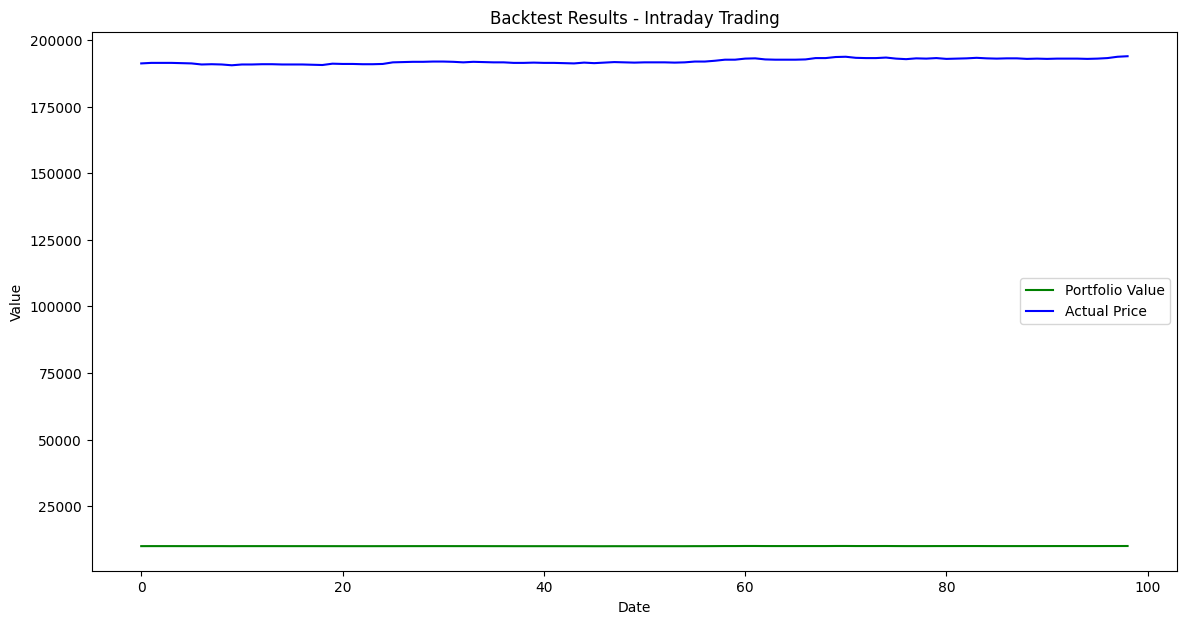

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras import layers , Model
from sklearn.preprocessing import MinMaxScaler
import os
from matplotlib.animation import FuncAnimation

def download_stock_data(ticker, start_date, end_date):
    df = yf.download(ticker, start=start_date, end=end_date)
    return df[['Close','Volume']].values

# 시계열 데이터 생성 함수
def create_sequences(data, seq_length):
    X, y = [],[]
    for i in range(len(data) - seq_length):
        X.append(data[i:i+ seq_length])
        y.append(data[i + seq_length, 0]) # 종가(Close) 예측
    return np.array(X), np.array(y)

# TimesNet 모델 구현
class TimeSeriesTransform(layers.Layer):
    def __init__(self, d_model, num_harmonics=64):
        super(TimeSeriesTransform, self).__init__()
        self.num_harmonics = num_harmonics
        self.dense = layers.Dense(d_model) # 출력 크기를 d_model로 맞춤

    def call(self, inputs):
        # 주파수 도메인으로 변환
        freq_data = tf.signal.rfft(inputs)
        freq_data = tf.concat([tf.math.real(freq_data), tf.math.imag(freq_data)], axis=-1)
        freq_data = freq_data[:,:,:self.num_harmonics]
        return self.dense(freq_data) # 출력 크키를 d_model로 맞춤

class TimeSeriesBlock(Model):
    def __init__(self, d_model, num_harmonics):
        super(TimeSeriesBlock, self).__init__()
        self.time_transform = TimeSeriesTransform(d_model, num_harmonics)
        self.multihead_attn = layers.MultiHeadAttention(num_heads=8, key_dim=d_model)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            layers.Dense(4 * d_model, activation='relu')
            , layers.Dense(d_model)
            , layers.Dropout(0.1)
        ])
    def call(self, x, training):
        x= self.time_transform(x)
        attn_output = self.multihead_attn(x, x)
        out1 = self.norm1(x + attn_output)
        ffn_output = self.ffn(out1, training=training)
        return self.norm2(out1 + ffn_output)

class TimesNet(Model):
    def __init__(self, input_dim, d_model, num_layers, num_harmonics, output_dim):
        super(TimesNet, self).__init__()
        self.input_proj = layers.Dense(d_model) # 입력 차원 맞추기
        self.blocks = [TimeSeriesBlock(d_model, num_harmonics) for _ in range(num_layers)]
        self.output_proj = layers.Dense(output_dim)

    def call(self, x, training):
        x = self.input_proj(x) # 입력 크기 조정
        for block in self.blocks:
            x = block(x, training)
        return self.output_proj(x[:, -1,:])

# 실시간 시각화 콜백 정의
class RealTimePlot(tf.keras.callbacks.Callback):
    def __init__(self, model, X_test, y_test, scaler, save_dir='plots'):
        super(RealTimePlot, self).__init__()
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.scaler = scaler
        self.save_dir = save_dir
        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
        self.fig, self.ax = plt.subplots()
        self.predicted = []
        self.actual = scaler.inverse_transform(np.c_[y_test.numpy(), np.zeros_like(y_test.numpy())])[:, 0]
        plt.ion()

    def on_epoch_end(self, epoch, logs=None):
        pred = self.model.predict(self.X_test)
        self.predicted = self.scaler.inverse_transform(np.c_[pred, np.zeros_like(pred)])[:, 0]

        self.ax.clear()
        self.ax.plot(self.actual, label='Actual Price', color='blue')
        self.ax.plot(self.predicted, label=f'Predicted Price (Epoch {epoch+1})', color='red')
        self.ax.set_title(f'Epoch {epoch+1}')
        self.ax.set_xlabel('Time Steps')
        self.ax.set_ylabel('Price')
        self.ax.legend()

        plt.draw()
        plt.pause(0.001)
        save_path = os.path.join(self.save_dir, f'epoch_{epoch+1}.png')
        self.fig.savefig(save_path)
        
    def on_train_end(self, logs=None):
        plt.ioff()
        plt.show()

# 백테스트 함수 정의
def backtest(model, X_test, y_test, scaler, initial_balance=10000):
    balance = initial_balance
    position = 0
    history = []

    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(np.c_[y_pred_scaled, np.zeros_like(y_pred_scaled)])[:, 0]
    y_true = scaler.inverse_transform(np.c_[y_test.numpy(), np.zeros_like(y_test.numpy())])[:, 0] 

    for i in range(len(y_pred) - 1):
        if y_pred[i+1] > y_pred[i]:
            if balance > 0:
                buy_amount = balance / y_true[i]
                position += buy_amount
                balance = 0
                action = 'BUY'
            else:
                action = 'HOLD'
        elif y_pred[i + 1] < y_pred[i]:
            if position > 0:
                balance += position * y_true[i]
                position = 0
                action = 'SELL'
            else:
                action = 'HOLD'
        else:
            action = 'HOLD'

        history.append({
            'Date': i,
            'Action': action,
            'Balance': balance,
            'Position': position,
            'Portfolio Value': balance + position * y_true[i],
            'Predicted Price': y_pred[i],
            'Actual Price': y_true[i]
        })

    final_value = balance + position * y_true[-1]
    history.append({
        'Date': len(y_pred) - 1,
        'Action': 'END',
        'Balance': balance,
        'Position': position,
        'Portfolio Value': final_value,
        'Predicted Price': y_pred[-1],
        'Actual Price': y_true[-1]
        })

    df_history = pd.DataFrame(history)
    return df_history

# 애니메이션 생성 함수
def create_animation(image_dir, output_file, fps=2):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    first_image = plt.imread(os.path.join(image_dir, image_files[0]))
    fig, ax = plt.subplots()
    img = ax.imshow(first_image)

    def update(frame):
        img.set_data(plt.imread(os.path. join(image_dir, image_files[frame])))
        return [img]

    anim = FuncAnimation(fig, update, frames=len(image_files), interval=1000/fps)
    anim.save(output_file, writer='imagemagick', fps=fps)
    plt.show()

# # 데이터 다운로드 및 전처리
# ticker = 'AAPL'
# start_date = '2021-01-01'
# end_date = '2023-01-01'
# data = download_stock_data(ticker, start_date, end_date)

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data_500)

# 시퀀스 데이터 생성
seq_length = 5
X, y = create_sequences(data, seq_length)

# 시간 순서에 따른 데이터 분할
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# TensorFlow 텐서로 변환
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# 모델 초기화 및 컴파일
input_dim= X_train.shape[-1] # 특성 수에 맞춤
d_model = 64
num_layers = 3
num_harmonics = 16
output_dim = 1

model = TimesNet(input_dim, d_model, num_layers, num_harmonics, output_dim)
model.compile(optimizer='adam', loss='mse')

# 실시간 시각화 콜백 인스턴스 생성
real_time_plot = RealTimePlot(model, X_test, y_test, scaler, save_dir='plots')

# 모델 학습
model.fit(
    X_train,
    y_train, 
    epochs=200, 
    batch_size=32, 
    validation_split=0.2, 
    callbacks=[real_time_plot]
    )

# 백테스트 실행
backtest_results = backtest(model, X_test, y_test, scaler, initial_balance=10000)

# 백테스트 결과 출력
print(backtest_results)

# 백테스트 결과 시각화
plt.figure(figsize=(14, 7))
plt.plot(backtest_results ['Date' ], backtest_results['Portfolio Value'], label='Portfolio Value', color='green')
plt.plot(backtest_results ['Date' ], backtest_results['Actual Price'], label='Actual Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Backtest Results - Intraday Trading')
plt.legend()
plt.show()

# # 애니메이션 생성
# create_animation(image_dir='plots', output_file='predictions animation.gif', fps=2)

In [13]:
test_data = data_000660[int(len(data_000660)-500):int(len(data_000660))]

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(test_data)

# 시퀀스 데이터 생성
seq_length = 5
X, y = create_sequences(data, seq_length)

# 시간 순서에 따른 데이터 분할
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# TensorFlow 텐서로 변환
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [27]:
backtest(model,X_test,y_test,scaler)

4/4 [==============================] - 0s 23ms/step


,Date,Action,Balance,Position,Portfolio Value,Predicted Price,Actual Price
0,0,BUY,0.000000,0.056850,10000.000000,176079.406250,175900.000000
1,1,SELL,10005.685048,0.000000,10005.685048,176350.156250,176000.000000
2,2,HOLD,10005.685048,0.000000,10005.685048,175998.093750,175800.000000
3,3,HOLD,10005.685048,0.000000,10005.685048,175929.609375,175700.000000
4,4,HOLD,10005.685048,0.000000,10005.685048,175653.046875,175300.000000
...,...,...,...,...,...,...,...
94,94,SELL,9891.166023,0.000000,9891.166023,174684.453125,172900.000000
95,95,BUY,0.000000,0.057207,9891.166023,174664.562500,172900.000000
96,96,HOLD,0.000000,0.057207,9879.725430,174667.437500,172700.015625
97,97,SELL,9896.886767,0.000000,9896.886767,174706.093750,173000.000000
